In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

DATA_DIR = '/content/drive/My Drive/proto_data/'
PICKLED_DIR = os.path.join(DATA_DIR, 'pickled/')
#CONLLU_DIR = os.path.join(DATA_DIR, 'WSJ_conllus/')
#MODEL_DIR = '../saved_models/'

PROTO_TSV = os.path.join(DATA_DIR, 'protoroles_eng_pb_08302015.tsv')
#GLOVE_FILE = {'100': os.path.join(DATA_DIR, 'glove.6B.100d.txt') }

SPLITS = ['train', 'dev', 'test'] 

PROPERTIES = ['instigation', 'volition', 'awareness', 'sentient',
'exists_as_physical', 'existed_before', 'existed_during', 'existed_after',
'created', 'destroyed', 'predicate_changed_argument', 'change_of_state', 
'changes_possession', 'change_of_location', 'stationary', 'location_of_event', 
'makes_physical_contact', 'manipulated_by_another']

PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'


In [0]:
import sys
sys.path.insert(0, '/content/drive/My Drive/proto_modules')

In [102]:
from collections import defaultdict
import os
import pickle
from tqdm import tqdm
import random
import math

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW, LBFGS
import scipy as sp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

#import data_utils

device:  cuda:0


In [0]:
from torch import unsqueeze
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, \
        pack_padded_sequence, pad_sequence


class Attention(nn.Module):
  def __init__(self,
               n_properties=None,
               specific_size=None):
    super(Attention, self).__init__()

    self.n_properties = n_properties

    self.layer_norm = nn.LayerNorm(self.n_properties * specific_size)

  def forward(self, x):
    B = x.shape[0]

    x = x.view(B, self.n_properties, -1) # (B, n_props, size_specific)

    attn_scores = torch.bmm(x, torch.transpose(x, 2, 1)) # (B, n_props, n_props)
    dists = F.softmax(attn_scores, -1)
    attn_weighted_sum = torch.bmm(dists, x)

    x = x + attn_weighted_sum

    x = self.layer_norm(x.view(B, -1))

    return x


class SPRL(nn.Module):
    def __init__(self,
            vocab_size=None,
            emb_size=None,
            h_size=None,
            shared_size=None,
            padding_idx=None,
            emb_np=None,
            properties=None,
            use_attention=False,
            use_lstm=False,
            direction_feature=False,
            train_jointly=False):
        super(SPRL, self).__init__()

        self.properties = properties
        self.n_properties = len(properties)
        self.direction_feature = direction_feature

        self.word_emb = nn.Embedding(
                vocab_size,
                emb_size,
                padding_idx=padding_idx)
        self.word_emb.weight.data.copy_(torch.Tensor(emb_np))
        self.word_emb.weight.requires_grad = False


        self.lstm = None
        if use_lstm:
          self.use_lstm = True
          directions = 2
          if not train_jointly:
            self.lstm = {}
            for p in self.properties:
              self.lstm[p] = MyLSTM(
                emb_size=emb_size,
                h_size=h_size,
                directions=directions)
          else:
            self.lstm = MyLSTM(
                emb_size=emb_size,
                h_size=h_size,
                directions=directions)

          concatenated_embs_size = 2*(directions*h_size)
        
        else:
          concatenated_embs_size = (2*emb_size) + int(direction_feature)

        self.attention = None
        if not use_attention:
          shared_size = concatenated_embs_size
          #shared_size = self.n_properties
          self.shared = nn.Sequential(
              nn.Linear(concatenated_embs_size, shared_size, bias=True),
              nn.ReLU(),
              )
          self.prop_specific = nn.Sequential(
              nn.Linear(shared_size, self.n_properties, bias=True),
              )
          
          #self.clf = nn.Linear(self.n_properties*shared_size, self.n_properties, bias=True)
          #self.clf = nn.Linear(shared_size, self.n_properties, bias=True)
        else: # "shared" not really best name here...
          self.attention = True
          self.first_guess = nn.Sequential(
              nn.Linear(concatenated_embs_size, self.n_properties, bias=True),
              #nn.ReLU()
              )
          
          self.updates = nn.Sequential(
              #nn.Sigmoid(),
              nn.Linear(self.n_properties, self.n_properties, bias=True),
              #nn.ReLU(),
              #nn.Linear(self.n_properties, self.n_properties, bias=False)
              #nn.ReLU(),
              )


    def forward(self, sents, sent_lens, preds, heads, updates=True):

        # Sort the sentences so that the LSTM can process properly
        B, _, = sents.shape


        if self.lstm != None:
          lens_sorted = sent_lens
          sents_sorted = sents
          indices = None
          if(len(sents) > 1):
              lens_sorted, indices = torch.sort(lens_sorted, descending=True)
              lens_sorted = lens_sorted.to(device)
              indices = indices.to(device)
              sents_sorted = sents_sorted.index_select(0, indices).to(device)
          w_embs = self.word_emb(sents_sorted)
          packed_lstm_input = pack_padded_sequence(
                  w_embs, lens_sorted, batch_first=True)

          if type(self.lstm) == type(dict()):
            lstm_outs = {p: self.lstm[p](packed_lstm_input, indices) for p in self.properties}
            lstm_outs = torch.stack(list(lstm_outs.values()), dim=0).sum(0)
          else:
            lstm_outs = self.lstm(packed_lstm_input, indices)
          pred_reps = lstm_outs[np.arange(B), preds] # expecting (B, h_size)
          head_reps = lstm_outs[np.arange(B), heads] # same as above
        else:
          w_embs = self.word_emb(sents)
          pred_reps = w_embs[np.arange(B), preds] # expecting (B, h_size)
          head_reps = w_embs[np.arange(B), heads] # same as above

        if self.direction_feature:
          head_before_pred = torch.unsqueeze((preds > heads), -1).float() # (B,)
          pred_head_cat = torch.cat([pred_reps, head_reps, head_before_pred], dim=-1) # (B, 2*h_size)
        else:
          pred_head_cat = torch.cat([pred_reps, head_reps], dim=-1) # (B, 2*h_size)

        x = pred_head_cat
        if self.attention == None:
          x = pred_head_cat # Experimenting with having no shared and learned rep
          x = self.shared(x) # (B, size_shared) # For lstm

          logits = self.prop_specific(x)
        else:
          x = self.first_guess(x)
          if updates:
            x_up = self.updates(x)
            logits = x + x_up # Residual model
          else:
            logits = x

        return logits

    def predict(self, logits):
        predictions = (logits.sign() + 1) / 2

        return predictions


class MyLSTM(nn.Module):
    def __init__(self,
            emb_size=None,
            h_size=None,
            directions=None):
        super(MyLSTM, self).__init__()

        self.lstm = nn.LSTM(
                input_size=emb_size,    
                hidden_size=h_size,
                num_layers=1,
                bidirectional=(directions == 2),
                batch_first=True,
                dropout=0.1,
                bias=True)
        
        self.lstm_drop = nn.Dropout(0.)

    def forward(self, packed_lstm_input, indices):
        outputs, _ = self.lstm(packed_lstm_input)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)

        # Unsort sentences to return to proper alignment with labels
        if len(outputs) > 1:
            outputs = unsort(outputs, indices)
          
        outputs = self.lstm_drop(outputs)

        return outputs

 
def unsort(batch, indices):
    indices_inverted = torch.argsort(indices)
    batch = batch.index_select(0, indices_inverted)
    return batch

In [0]:

def train_lstm(args, model, X, y):
    epochs = args['epochs']
    batch_size = args['batch_size']
    lr = args['lr']

    for name, param in model.named_parameters():
      if 'updates' in name and 'weight' in name:
        original_weights = param.detach().clone()

    # Data loaders
    loader_train = data_loader(X['train'], y['train'],
            batch_size=batch_size, shuffle_idx=True)
    loader_dev = data_loader(X['dev'], y['dev'],
            batch_size=batch_size, shuffle_idx=False)
    n_train_batches = math.ceil(len(X['train']) / batch_size)
    n_dev_batches = math.ceil(len(X['dev']) / batch_size)

    # Optimizer
    opt = Adam(model.parameters(), lr=lr, betas=[0.9, 0.999])
    #opt = AdamW(model.parameters(), lr=lr, betas=[0.9, 0.999])
    #opt = LBFGS(model.parameters())

    # Train loop
    training_losses = []
    dev_losses = [4]
    steps = 0
    cma = 0
    try:
        for e in range(epochs):
            model.train()
            steps_ = 0
            for b in tqdm(
                    range(n_train_batches), 
                    ascii=True, 
                    desc=f'Epoch {e+1}/{epochs} progress',
                    position=0,
                    leave=True,
                    ncols=80):
                opt.zero_grad()
                sents, sent_lens, preds, heads, labels = next(loader_train)

                if args['use_attention']:
                  stop_training_lower = e >= 5

                  step_updates = e > 0 or steps_ > (n_train_batches / 2)
                  #if step_updates:
                  if stop_training_lower:
                    for p in model.parameters():
                      p.requires_grad = False
                    for p in model.updates.parameters():
                      p.requires_grad = True
                    
                    logits = model(sents, sent_lens, preds, heads)
                    # loss = bce_loss(logits, labels)
                    # loss.backward()
                    # opt.step()
                    # opt.zero_grad()

                  # Normal step
                  if not stop_training_lower:
                    for p in model.parameters():
                      p.requires_grad = True
                    for p in model.updates.parameters():
                      p.requires_grad = False

                      logits = model(sents, sent_lens, preds, heads, updates=False)
                    # if b == n_train_batches - 1:
                    #   print(logits[0])
                
                else: # Not attention
                  logits = model(sents, sent_lens, preds, heads)

                loss = bce_loss(logits, labels)
                loss.backward()
                opt.step()
                steps_ += 1
                cma = (loss.item() + (steps_-1) * cma) / steps_
                training_losses.append(cma)
            
            steps += steps_
        
            with torch.no_grad():
              model.eval()
              tp = 0
              fp = 0
              fn = 0
              dev_loss = 0
              for b in tqdm(range(n_dev_batches), ascii=True, desc=f'Evaluating progress', ncols=80, position=0, leave=True):
                sents, sent_lens, preds, heads, labels = next(loader_dev)
                results_, metrics_, dev_loss_ = evaluate(args, model, sents, sent_lens, preds, heads, labels)
                tp += results_['tp']
                fp += results_['fp']
                fn += results_['fn']
                dev_loss += dev_loss_.item()

              if args['use_attention'] and args['show_weights']:
                for name, param in model.named_parameters():
                  if 'updates' in name and 'weight' in name:
                    updates_weights = param
                with torch.no_grad():
                  show_weights((updates_weights - original_weights).cpu(), properties=model.properties)
                  #show_weights((updates_weights).cpu(), properties=model.properties)
              
              F, precision, recall = F_precision_recall(tp, fp, fn)
              dev_losses.append(np.mean(dev_loss))

              print(f"Epoch {e}, F={F*100:.2f}, p={precision*100:.2f}, r={recall*100:.2f}")

    except KeyboardInterrupt:
        pass
    # End of train loop

    fig, ax = plt.subplots(nrows=2, ncols=1)

    ax[0].plot(np.arange(len(training_losses)), np.array(training_losses), color='orange')
    ax[1].plot(np.arange(0, steps+1, n_train_batches), np.array(dev_losses), color='blue')
    fig.show()
    
    return


def show_weights(weights, properties=None, cmap='RdBu'):
    fig, ax = plt.subplots()

    
    vmax = weights.max()
    vmin = weights.min()
    if type(weights) == type(torch.randn(1)):
      vmax = vmax.item()
      vmin = vmin.item()
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    ax.set_xticks(np.arange(len(properties)))
    ax.set_yticks(np.arange(len(properties)))
    ax.set_xticklabels(properties)
    ax.set_yticklabels(properties)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")

    plt.imshow(weights, cmap=cmap, norm=norm)
    cbar = plt.colorbar()

    return


def bce_loss(logits, labels):
    # Expected labels : (B, num_properties)
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    return loss


def data_loader(X, y, batch_size=None, shuffle_idx=False):
    data = list(zip(X, y))
    idx = list(range(len(data)))
    while True:
        if shuffle_idx:
            random.shuffle(idx) # In-place shuffle
        
        for span in idx_spans(idx, batch_size):
            batch = [data[i] for i in span]
            yield prepare_batch(batch)


def idx_spans(idx, span_size):
    for i in range(0, len(idx), span_size):
        yield idx[i:i+span_size]


def prepare_batch(batch):
    # batch[i] = X, y
    batch_size = len(batch)
    sent_lens = torch.LongTensor([len(x[0][0]) for x in batch])
    max_length = torch.max(sent_lens).item()
    n_properties = len(batch[0][1])

    # Zero is padding index
    sents = torch.zeros((batch_size, max_length)).long().to(device)
    preds = torch.zeros(batch_size).long().to(device)
    heads = torch.zeros(batch_size).long().to(device)
    labels = torch.zeros(batch_size, n_properties).to(device)

    for i, (X_batch, y_batch) in enumerate(batch):
        sent, (pred_idx, head_idx) = X_batch
        sents[i,:len(sent)] = torch.LongTensor(sent)
        preds[i] = pred_idx
        heads[i] = head_idx
        labels[i] = torch.tensor(y_batch)

    return sents, sent_lens, preds, heads, labels

In [0]:
def evaluate(args, model, sents, sent_lens, preds, heads, labels):
    # Get predictions
    logits = model(sents, sent_lens, preds, heads)
    dev_loss = bce_loss(logits, labels)
    predictions = model.predict(logits)

    predictions, labels = predictions.cpu().numpy(), labels.cpu().numpy()
    results, metrics = get_results_metrics()

    return results, metrics, dev_loss


def get_results_metrics(predictions, labels):
    n_correct = (predictions == labels).astype(int).sum()

    # Precision, Recall
    eq = predictions == labels
    neq = predictions != labels

    pos_preds = predictions == 1
    neg_preds = predictions == 0

    tp = np.where(pos_preds, eq, 0).astype(int).sum()
    fp = np.where(pos_preds, neq, 0).astype(int).sum()
    fn = np.where(neg_preds, neq, 0).astype(int).sum()
    
    results = {
            'tp': tp,
            'fp': fp,
            'fn': fn
            }

    F, precision, recall = F_precision_recall(tp, fp, fn)
    metrics = {'F': F, 'precision': precision, 'recall': recall}

    return results, metrics
    

def F_precision_recall(tp, fp, fn):
    if tp + fp > 0.:
        precision = tp / (tp + fp)
    else:
        precision = 0.

    if tp + fn > 0.:
        recall = tp / (tp + fn)
    else:
        recall = 0.

    if precision + recall > 0.:
        F = (2 * precision * recall) / (precision + recall)
    else:
        F = 0.

    return F, precision, recall


def micro_average(results):
    tp, fp, fn = 0, 0, 0
    for v in results.values():
        tp += v['tp']
        fp += v['fp']
        fn += v['fn']
    
    return F_precision_recall(tp, fp, fn)


In [0]:
def get_data(args):
    df = pd.read_csv(PROTO_TSV, sep='\t')

    # Sentences
    sent_ids = set(df['Sentence.ID'].tolist())
    sents_path = os.path.join(PICKLED_DIR, 'sents.pkl')
    sents = None
    with open(sents_path, 'rb') as f:
      sents = pickle.load(f)

    # Dependency data
    # dependencies_path = os.path.join(PICKLED_DIR, 'dependencies.pkl')
    # with open(dependencies_path, 'rb') as f:
    #     deps, deps_just_tokens = pickle.load(f)  
    # sents['dependencies'] = deps
    # sents['deps_just_tokens'] = deps_just_tokens


    # Instances
    path = os.path.join(PICKLED_DIR, 'instances.pkl')
    proto_instances = None
    possible = None # Data to compare to SPRL paper
    with open(path, 'rb') as f:
      proto_instances, possible = pickle.load(f)

    # Word embedding data
    w2e = None
    path = os.path.join(PICKLED_DIR, f"glove_{args['glove_d']}.pkl")
    with open(path, 'rb') as f:
      w2e = pickle.load(f)

    w2i, i2w = None, None
    emb_np = None
    X, y = None, None
    dicts_path = os.path.join(PICKLED_DIR, 'dicts.pkl')
    with open(dicts_path, 'rb') as f:
        w2i, i2w = pickle.load(f)
    
    emb_np_path = os.path.join(PICKLED_DIR, 'emb_np.pkl')
    with open(emb_np_path, 'rb') as f:
        emb_np = pickle.load(f)
    
    lstm_data_path = os.path.join(PICKLED_DIR, 'lstm_data.pkl')
    with open(lstm_data_path, 'rb') as f:
        X, y = pickle.load(f)

    return {'df': df, 
            'proto_instances': proto_instances, 
            'possible': possible,
            'sents': sents,
            'w2e': w2e,
            'sent_ids': sent_ids,
            'lstm_data': (X,y),
            'dicts': (w2i, i2w),
            'emb_np': emb_np}


In [0]:
def co_occurrences(y_train):
  n_props = y_train[0].shape[0]
  co_occur = np.zeros((n_props, n_props))
  anti_occur = np.zeros((n_props, n_props))
  for labels in y_train:
    for i in range(n_props):
      for j in range(i+1, n_props):
        if labels[i] == 1:
          if labels[j] == 1:
            co_occur[i,j] += 1
            co_occur[j,i] += 1
          else:
            anti_occur[i,j] += 1
            anti_occur[j,i] += 1
  

  return co_occur, anti_occur


In [0]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

In [0]:
def bootstrap_conf_interval(predictions, B=10000):
  predictions = predictions.cpu().numpy() # (n_test,18)
  indices = np.arange(predictions.shape[0])
  N = len(predictions)
  for b in B:
    idx = np.random.choice(indices)
    curr_preds = predictions[idx]
    curr_labels = labels[idx]
    results, metrics = get_results_metrics(curr_preds, curr_labels)
    micro_f1 = metrics['F']
    bs_samples.append(micro_f1)
  
  return np.percentile(bs_samples, [0.025, 0.975])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
Epoch 2/10 progress:   9%|##                     | 7/78 [00:00<00:01, 68.28it/s]

Epoch 0, F=65.42, p=63.58, r=67.37


Epoch 3/10 progress:   9%|##                     | 7/78 [00:00<00:01, 66.53it/s]

Epoch 1, F=67.84, p=66.09, r=69.67


Epoch 4/10 progress:   9%|##                     | 7/78 [00:00<00:01, 65.79it/s]

Epoch 2, F=69.48, p=67.94, r=71.10


Epoch 5/10 progress:   9%|##                     | 7/78 [00:00<00:01, 66.31it/s]

Epoch 3, F=70.66, p=69.30, r=72.07


Epoch 6/10 progress:  10%|##3                    | 8/78 [00:00<00:00, 76.90it/s]

Epoch 4, F=70.68, p=69.31, r=72.10


Epoch 7/10 progress:  10%|##3                    | 8/78 [00:00<00:00, 76.36it/s]

Epoch 5, F=75.88, p=80.01, r=72.16


Epoch 8/10 progress:  10%|##3                    | 8/78 [00:00<00:00, 75.31it/s]

Epoch 6, F=76.42, p=79.59, r=73.49


Epoch 9/10 progress:   9%|##                     | 7/78 [00:00<00:01, 69.96it/s]

Epoch 7, F=76.45, p=80.11, r=73.11


Epoch 10/10 progress:  10%|##2                   | 8/78 [00:00<00:00, 78.02it/s]

Epoch 8, F=76.58, p=80.10, r=73.36


Evaluating progress: 100%|######################| 10/10 [00:00<00:00, 80.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


Epoch 9, F=76.81, p=79.74, r=74.10


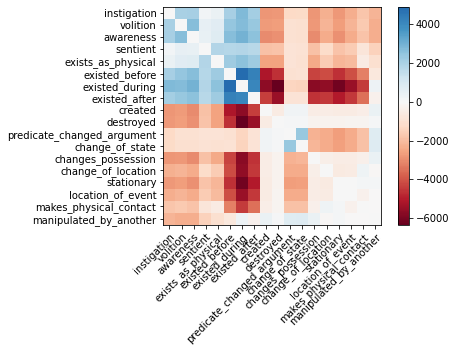

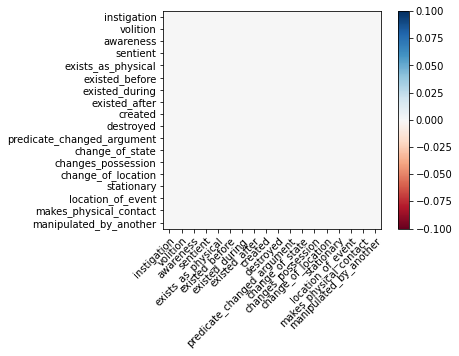

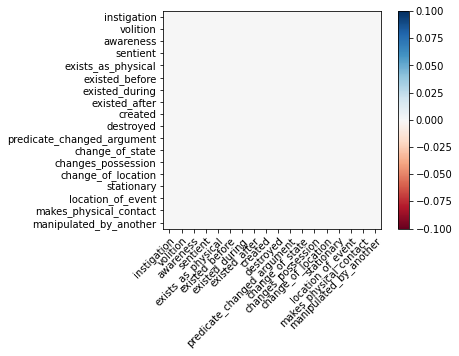

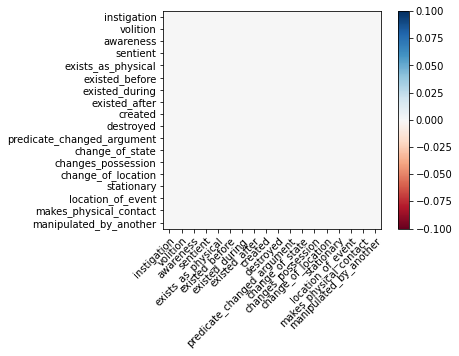

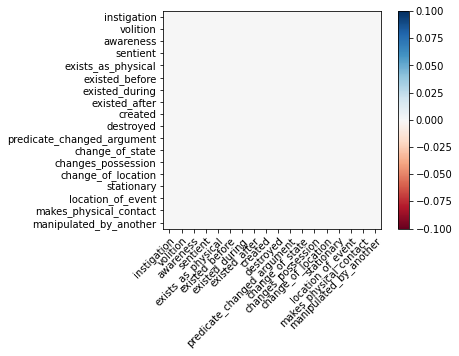

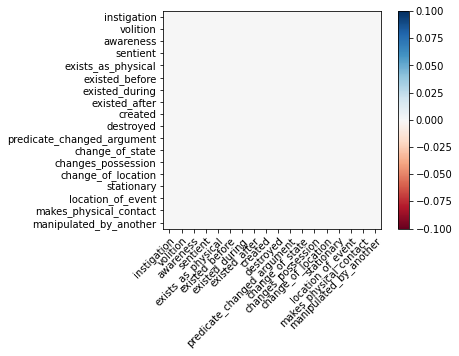

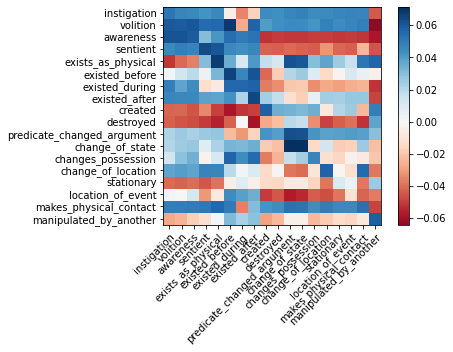

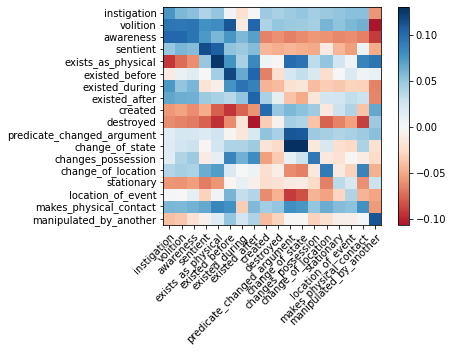

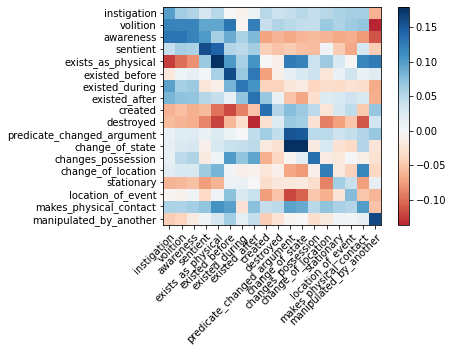

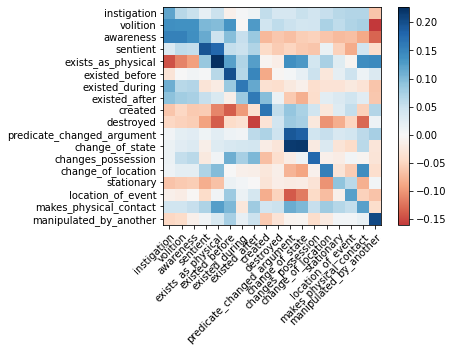

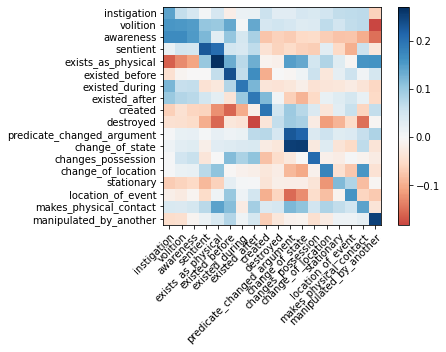

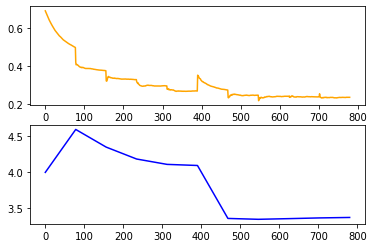

In [115]:
args = {
    'epochs': 10,
    'seed': 7,
    'lr': 1e-3,
    'batch_size': 100,
    'h_size': 100,
    #'shared_size': 300,
    'glove_d': 300,
    'use_attention': True,
    'use_lstm': False,
    'show_weights': True,
    'train_jointly': True
}

seed = args['seed']

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

data = get_data(args)

w2i, i2w = data['dicts']
emb_np = data['emb_np']
X, y = data['lstm_data']

co_occur, anti_occur = co_occurrences(y['train'])
#show_weights(co_occur, properties=PROPERTIES, cmap='Greens')
#show_weights(anti_occur, properties=PROPERTIES, cmap='Reds')
show_weights(co_occur - anti_occur, properties=PROPERTIES)

model = SPRL(
    vocab_size=len(w2i),
    emb_size=int(args['glove_d']),
    h_size=args['h_size'],
    #shared_size=args['shared_size'],
    padding_idx=w2i[PAD_TOKEN],
    emb_np=emb_np,
    properties=PROPERTIES,
    use_attention=args['use_attention'],
    use_lstm=args['use_lstm'],
    direction_feature=not args['use_lstm'],
    train_jointly=args['train_jointly'])
model.to(device)

train_lstm(args, model, X, y)